In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [61]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [62]:
model_path_name = "previous_game_features"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [63]:
if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)
    print(f"Using features that account for previous results from entire game (not just previous play). Don't start collecting till at least 10 plays", file=text_file)

In [64]:
dataset = pd.read_pickle("data/advanced_dataset2.pkl")

In [65]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

15867.2
1983.4


In [66]:
train_index_stop = 15970 # this is the first index of a new pitcher
val_index_stop = 17987 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [67]:
train_X = training_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
train_y = training_set['RUNPASS']

val_X = validation_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
val_y = validation_set['RUNPASS']

test_X = test_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
test_y = test_set['RUNPASS']

In [68]:
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Input features: {train_X.columns.values}", file=text_file)

In [69]:
# have to convert to numerics for XGBoost 
mapping = {'R' : 0,
           'P': 1
           }

In [70]:
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [71]:
train_y.value_counts(normalize=True)

RUNPASS
1    0.611334
0    0.388666
Name: proportion, dtype: float64

In [72]:
bparams = {'max_depth': 6,
 'learning_rate': 0.23414476853402916,
 'n_estimators': 800,
 'subsample': 0.7000000000000001,
 'min_child_weight': 4}

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **bparams)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.36143	validation_0-logloss:0.62100	validation_0-auc:0.74126
[1]	validation_0-error:0.35102	validation_0-logloss:0.59787	validation_0-auc:0.75496
[2]	validation_0-error:0.31532	validation_0-logloss:0.58204	validation_0-auc:0.76062
[3]	validation_0-error:0.30094	validation_0-logloss:0.57091	validation_0-auc:0.76183
[4]	validation_0-error:0.29945	validation_0-logloss:0.56396	validation_0-auc:0.76253
[5]	validation_0-error:0.30193	validation_0-logloss:0.55931	validation_0-auc:0.76342
[6]	validation_0-error:0.29301	validation_0-logloss:0.55412	validation_0-auc:0.76726
[7]	validation_0-error:0.29103	validation_0-logloss:0.55153	validation_0-auc:0.76860
[8]	validation_0-error:0.29003	validation_0-logloss:0.54995	validation_0-auc:0.76936
[9]	validation_0-error:0.29103	validation_0-logloss:0.54730	validation_0-auc:0.77083
[10]	validation_0-error:0.29648	validation_0-logloss:0.54642	validation_0-auc:0.76997
[11]	validation_0-error:0.29499	validation_0-logloss:0.54556	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23414476853402916, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
clf.evals_result()['validation_0']['error'][clf.best_iteration]

0.28061477441745164

In [74]:
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
#                                         objective='objective=multi:softmax', eval_metric=['merror','mlogloss'])
# clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

In [75]:
def objective(trial, train_X, train_y, val_X, val_y, train_weights=None, val_weights=None):
    param = {
             "max_depth": trial.suggest_int('max_depth', 2, 20,step=1),
              "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
              "n_estimators": trial.suggest_int('n_estimators', 50, 2950,step=100),
              "subsample" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
              "min_child_weight" : trial.suggest_int('min_child_weight', 1, 10, step=1), 
              "colsample_bytree" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
            }
    clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **param)
    clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=0)  

    best_error = clf.evals_result()['validation_0']['error'][clf.best_iteration]
    return best_error


In [76]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda x : objective(x, train_X, train_y, val_X, val_y), n_trials=30)
print(study.best_trial)

[I 2024-05-05 20:44:45,214] A new study created in memory with name: no-name-84d61341-5b31-481a-8cbd-7bcb409bf99e
[I 2024-05-05 20:44:45,648] Trial 0 finished with value: 0.3039167079821517 and parameters: {'max_depth': 15, 'learning_rate': 0.21687344550189555, 'n_estimators': 2050, 'subsample': 0.4, 'min_child_weight': 6}. Best is trial 0 with value: 0.3039167079821517.
[I 2024-05-05 20:44:45,971] Trial 1 finished with value: 0.3292017848289539 and parameters: {'max_depth': 7, 'learning_rate': 0.06464930318225726, 'n_estimators': 1850, 'subsample': 0.2, 'min_child_weight': 2}. Best is trial 0 with value: 0.3039167079821517.
[I 2024-05-05 20:44:47,101] Trial 2 finished with value: 0.28705999008428357 and parameters: {'max_depth': 19, 'learning_rate': 0.1128667870243557, 'n_estimators': 2550, 'subsample': 0.9, 'min_child_weight': 10}. Best is trial 2 with value: 0.28705999008428357.
[I 2024-05-05 20:44:47,674] Trial 3 finished with value: 0.2840852751611304 and parameters: {'max_depth':

FrozenTrial(number=23, state=TrialState.COMPLETE, values=[0.28011898859692613], datetime_start=datetime.datetime(2024, 5, 5, 20, 45, 1, 274398), datetime_complete=datetime.datetime(2024, 5, 5, 20, 45, 1, 833119), params={'max_depth': 7, 'learning_rate': 0.17124698885746417, 'n_estimators': 950, 'subsample': 0.9, 'min_child_weight': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=20, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=2950, log=False, low=50, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=23, value=None)


In [77]:
print(f"Best Params = {study.best_params}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Params = {study.best_params}", file=text_file)

Best Params = {'max_depth': 7, 'learning_rate': 0.17124698885746417, 'n_estimators': 950, 'subsample': 0.9, 'min_child_weight': 1}


In [78]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **study.best_params)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.37234	validation_0-logloss:0.62929	validation_0-auc:0.74958
[1]	validation_0-error:0.34755	validation_0-logloss:0.60703	validation_0-auc:0.75636
[2]	validation_0-error:0.32375	validation_0-logloss:0.58984	validation_0-auc:0.76809
[3]	validation_0-error:0.32226	validation_0-logloss:0.57783	validation_0-auc:0.76855
[4]	validation_0-error:0.29846	validation_0-logloss:0.57021	validation_0-auc:0.76830
[5]	validation_0-error:0.29251	validation_0-logloss:0.56328	validation_0-auc:0.76975
[6]	validation_0-error:0.29450	validation_0-logloss:0.55693	validation_0-auc:0.77227
[7]	validation_0-error:0.29152	validation_0-logloss:0.55163	validation_0-auc:0.77421
[8]	validation_0-error:0.28805	validation_0-logloss:0.54811	validation_0-auc:0.77529
[9]	validation_0-error:0.28607	validation_0-logloss:0.54468	validation_0-auc:0.77771
[10]	validation_0-error:0.29251	validation_0-logloss:0.54306	validation_0-auc:0.77894
[11]	validation_0-error:0.29598	validation_0-logloss:0.54069	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.17124698885746417, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=950, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [79]:
pickle.dump(clf, open(f"{DIRECTORY_PATH}/xgb_model.pkl", "wb"))

In [80]:
best_val_merror = clf.evals_result()['validation_0']['error'][clf.best_iteration]
best_val_mlogloss = clf.evals_result()['validation_0']['logloss'][clf.best_iteration]
best_val_auc = clf.evals_result()['validation_0']['auc'][clf.best_iteration]

print(f"Best Val error = {best_val_merror}")
print(f"Best Val logloss = {best_val_mlogloss}")
print(f"Best Val AUC = {best_val_auc}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Val error = {best_val_merror}", file=text_file)
    print(f"Best Val logloss = {best_val_mlogloss}", file=text_file)
    print(f"Best Val AUC = {best_val_auc}", file=text_file)

Best Val error = 0.2845810609816559
Best Val logloss = 0.5327230582561345
Best Val AUC = 0.7856480984805936


In [81]:
#y_pred_probs = clf.predict_proba(val_X)

In [82]:
# y_pred_probs = clf.predict_proba(val_X)
y_pred = clf.predict(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)


------------------ Confusion Matrix -----------------

     R     P
R  442   309
P  265  1001


In [83]:
# row i represents all true class i
# recall = (np.diagonal(confusion_matrix)/np.sum(confusion_matrix,axis=1)).round(3)
print(classification_report(val_y, y_pred, target_names=list(mapping.keys())))

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(val_y, y_pred, target_names=list(mapping.keys())), file=text_file)

              precision    recall  f1-score   support

           R       0.63      0.59      0.61       751
           P       0.76      0.79      0.78      1266

    accuracy                           0.72      2017
   macro avg       0.69      0.69      0.69      2017
weighted avg       0.71      0.72      0.71      2017



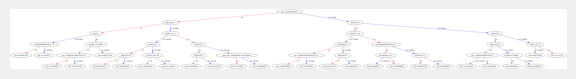

In [55]:
xgb.plot_tree(clf)
plt.show()

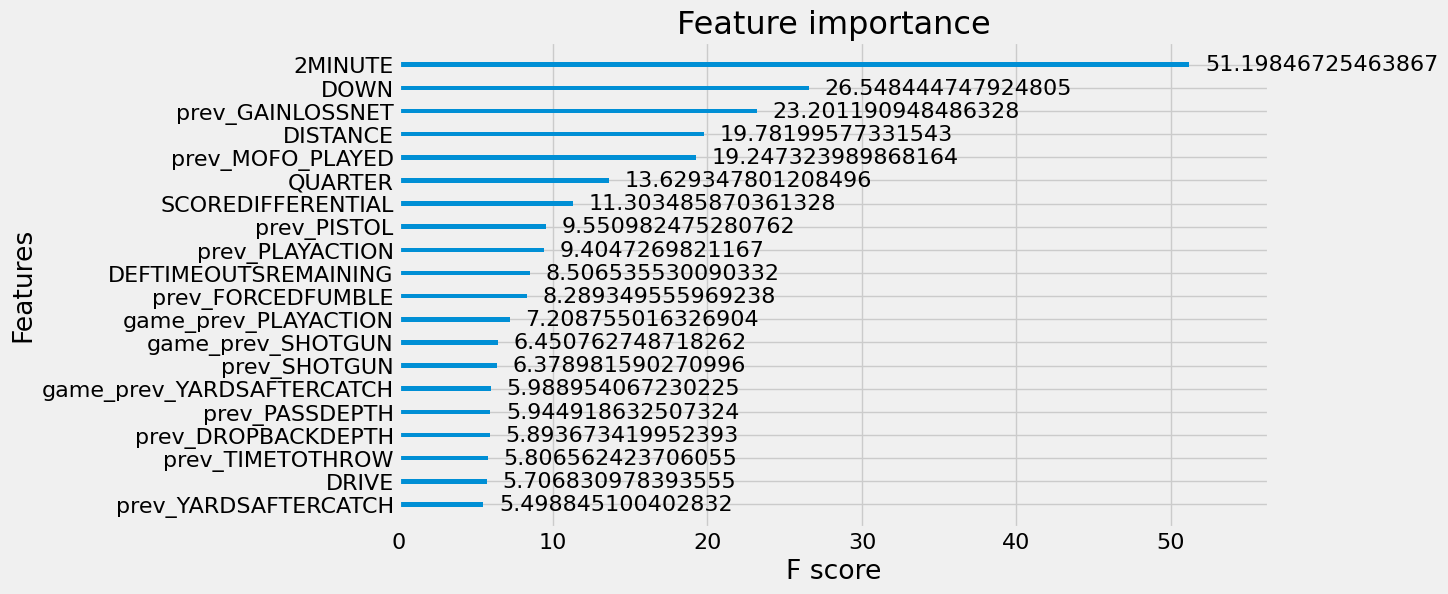

In [84]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png", bbox_inches = 'tight')
plt.show()

In [85]:
from sklearn.metrics import accuracy_score
y_test_pred = clf.predict(test_X)

In [86]:
accuracy_score(test_y, y_test_pred)

0.713589604764483

In [87]:

print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ TEST DATA Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())), file=text_file)



------------------ TEST DATA Confusion Matrix -----------------

     R    P
R  441  280
P  249  877
              precision    recall  f1-score   support

           R       0.64      0.61      0.63       721
           P       0.76      0.78      0.77      1126

    accuracy                           0.71      1847
   macro avg       0.70      0.70      0.70      1847
weighted avg       0.71      0.71      0.71      1847

